In [3]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import check_nan, check_unique
from matplotlib import gridspec
from matplotlib import rcParams
from collections import Counter

from datetime import datetime, timedelta


import requests
import urllib.parse
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily
import geopy.distance
from geopy.distance import distance
from mpl_toolkits.basemap import Basemap

#Paramètres graphiques 
rcParams['figure.figsize'] = 15,8 #Taille de la figure affichée
sns.set_style("darkgrid")#style de l'arrière plan de seaborn 
sns.set_palette("pastel")#Couleurs utilisées dans les graphiques 
plt.rcParams["figure.dpi"] = 200 #dpi = dot per inch , résolution des graphiques 
pd.set_option('display.max_columns', 500) #Nombre de colonne maximum du dataframe à afficher

# import warnings
# warnings.simplefilter(action='ignore')

# Lecture et mise en forme des données

# Données des retards réels :

In [4]:
data=pd.read_csv("./data/delays.csv")
data.columns= ["save_datetime","id_train_complet","transporteur","date_depart","depart_destination","arrivee_prevue","retard","nom_station"]

data["save_datetime"]=pd.to_datetime(data["save_datetime"])
data["date_depart"]=pd.to_datetime(data["date_depart"])


#Drop des lignes avec une horaire prévue inexploitatble :
df=data[data["arrivee_prevue"]!='Nie dotyczy']

#Conversion du retard en entier : 
df["retard"]=df["retard"].str.split(" ").str[0].astype('int')

#df[["depart","destination"]]= df["depart_destination"].str.split(" - ", expand=True)

new_id=df["id_train_complet"].str.extract(r"(\d+)(\/\d+)?\s*(\(\d+\)|)?(\s*)(.*|[a-zA-Z\u00C0-\u017F]*)").add_prefix('index_part')
df=df.merge(new_id, left_index=True, right_index=True).drop(['index_part3'], axis=1).rename(columns={"index_part4": "index_part3","index_part0":"id_train"})

df=df.fillna("")

#On ne garde que les lignes qui nous intéressent 
df =df.sort_values("save_datetime").drop_duplicates(["id_train","transporteur","date_depart","depart_destination","arrivee_prevue","nom_station"],keep="last").sort_values("save_datetime")

df["arrivee_prevue"]=pd.to_datetime(df["arrivee_prevue"], format='%H:%M').dt.time
#df["save_datetime"]=df["save_datetime"].dt.strftime('%Y-%m-%d %H:%M:%S')

print("Shape du dataset d'origine :", data.shape)
print("Shape du dataset contenant uniquement les lignes qui nous intéressent : ",df.shape)
df.head()

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Shape du dataset d'origine : (3718170, 8)
Shape du dataset contenant uniquement les lignes qui nous intéressent :  (224446, 12)


,save_datetime,id_train_complet,transporteur,date_depart,depart_destination,arrivee_prevue,retard,nom_station,id_train,index_part1,index_part2,index_part3
175,2022-05-16,95697,PKP SKM w Trójmieście Sp. z o.o.,2022-05-15,Gdańsk Zaspa - Wejherowo,23:38:00,24,Reda Pieleszewo,95697,,,
68,2022-05-16,91888/9,Koleje Mazowieckie,2022-05-16,Siedlce - Warszawa Zachodnia,00:01:00,2,Warszawa Stadion,91888,/9,,
111,2022-05-16,59486,PKP SKM w Trójmieście Sp. z o.o.,2022-05-15,Gdynia Cisowa - Gdańsk Główny,23:54:00,9,Gdańsk Żabianka-AWFiS,59486,,,
119,2022-05-16,95699,PKP SKM w Trójmieście Sp. z o.o.,2022-05-16,Gdańsk Śródmieście - Wejherowo,00:04:00,0,Gdynia Wzgórze Św.Maksymiliana,95699,,,
116,2022-05-16,95699,PKP SKM w Trójmieście Sp. z o.o.,2022-05-16,Gdańsk Śródmieście - Wejherowo,00:01:00,0,Gdynia Redłowo,95699,,,


# Feature preprocessing : 

## Features avant génération des lignes : 

In [5]:
#Features qui n'évoluent pas en fonction du timestamp auquel on prédit 
df[['depart','destination']] = df["depart_destination"].str.split(" - ",expand=True,)
df.head()

,save_datetime,id_train_complet,transporteur,date_depart,depart_destination,arrivee_prevue,retard,nom_station,id_train,index_part1,index_part2,index_part3,depart,destination
175,2022-05-16,95697,PKP SKM w Trójmieście Sp. z o.o.,2022-05-15,Gdańsk Zaspa - Wejherowo,23:38:00,24,Reda Pieleszewo,95697,,,,Gdańsk Zaspa,Wejherowo
68,2022-05-16,91888/9,Koleje Mazowieckie,2022-05-16,Siedlce - Warszawa Zachodnia,00:01:00,2,Warszawa Stadion,91888,/9,,,Siedlce,Warszawa Zachodnia
111,2022-05-16,59486,PKP SKM w Trójmieście Sp. z o.o.,2022-05-15,Gdynia Cisowa - Gdańsk Główny,23:54:00,9,Gdańsk Żabianka-AWFiS,59486,,,,Gdynia Cisowa,Gdańsk Główny
119,2022-05-16,95699,PKP SKM w Trójmieście Sp. z o.o.,2022-05-16,Gdańsk Śródmieście - Wejherowo,00:04:00,0,Gdynia Wzgórze Św.Maksymiliana,95699,,,,Gdańsk Śródmieście,Wejherowo
116,2022-05-16,95699,PKP SKM w Trójmieście Sp. z o.o.,2022-05-16,Gdańsk Śródmieście - Wejherowo,00:01:00,0,Gdynia Redłowo,95699,,,,Gdańsk Śródmieście,Wejherowo


In [6]:
#df["datetime_save"]=df["save_datetime"].dt.strftime('%Y-%m-%d %H:%M:%S')

#### Ancienne fonction pour déterminer les trajets des trains 

## Génération des lignes 

In [7]:
#Paramètres : 
#Fenêtre de prédictions en minutes : 
P=2*60 

#### Première version (très lente)

#### Deuxième version (plus rapide ~2-3 min)

In [8]:
# autre idée : 
list_df=[]
for id_train in tqdm(df.sort_values(["id_train","save_datetime"]).set_index("save_datetime")["id_train"].unique().tolist()): 
    df_used= df[df["id_train"]==id_train]
    date_index= pd.date_range(
            start=df_used["save_datetime"].min()-timedelta(minutes=P),
            end=df_used["save_datetime"].max(),
            freq="5T")
    df_temp =df_used.sort_values(["save_datetime","arrivee_prevue"]).drop_duplicates(["save_datetime"],keep="first").set_index("save_datetime").reindex(date_index,method="backfill").reset_index().rename(columns={"index":"save_datetime"})
    df_temp = pd.concat([df_temp, df_used]).drop_duplicates(["save_datetime","arrivee_prevue"])#Permet de garder les lignes avec des stations qui sont desservies dans le même save_datetime
    list_df.append(df_temp)
df_all = pd.concat(list_df)

100%|██████████████████████████████████████████████████████████████████████████████| 3447/3447 [02:06<00:00, 27.17it/s]


In [9]:
df_all.shape

(11811450, 14)

In [10]:
check_nan(df_all)

Valeurs nan dans save_datetime : 0
Valeurs nan dans id_train_complet : 0
Valeurs nan dans transporteur : 0
Valeurs nan dans date_depart : 0
Valeurs nan dans depart_destination : 0
Valeurs nan dans arrivee_prevue : 0
Valeurs nan dans retard : 0
Valeurs nan dans nom_station : 0
Valeurs nan dans id_train : 0
Valeurs nan dans index_part1 : 0
Valeurs nan dans index_part2 : 0
Valeurs nan dans index_part3 : 0
Valeurs nan dans depart : 0
Valeurs nan dans destination : 0


In [11]:
df_all.head()

,save_datetime,id_train_complet,transporteur,date_depart,depart_destination,arrivee_prevue,retard,nom_station,id_train,index_part1,index_part2,index_part3,depart,destination
0,2022-05-16 18:25:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-16,Warszawa Zachodnia - Białystok,20:18:00,8,Warszawa Centralna,10102,/3,,ZAMENHOF,Warszawa Zachodnia,Białystok
1,2022-05-16 18:30:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-16,Warszawa Zachodnia - Białystok,20:18:00,8,Warszawa Centralna,10102,/3,,ZAMENHOF,Warszawa Zachodnia,Białystok
2,2022-05-16 18:35:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-16,Warszawa Zachodnia - Białystok,20:18:00,8,Warszawa Centralna,10102,/3,,ZAMENHOF,Warszawa Zachodnia,Białystok
3,2022-05-16 18:40:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-16,Warszawa Zachodnia - Białystok,20:18:00,8,Warszawa Centralna,10102,/3,,ZAMENHOF,Warszawa Zachodnia,Białystok
4,2022-05-16 18:45:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-16,Warszawa Zachodnia - Białystok,20:18:00,8,Warszawa Centralna,10102,/3,,ZAMENHOF,Warszawa Zachodnia,Białystok


### GPS loc & Weather

#### loc

In [12]:
#3min pour api loc

In [13]:
def get_loc(loc_list):
    loc={}
    for i in loc_list:
        url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote("Pologne "+i) + '?format=json'
        response = requests.get(url).json()
        if len(response)!=0:
            loc[i]=[float(response[0]['lon']),float(response[0]['lat'])]
        else:
            loc[i]=[None,None]
    return loc

In [14]:
dep_gare=set(df["depart"].unique())
arr_gare=set(df["destination"].unique())
gare=dep_gare.union(arr_gare)
gare_loc=get_loc(gare)

gare_loc['Loecknitz']=[14.2153,53.4528]
gare_loc['Tantow']=[14.3333,53.2667]
gare_loc['Jagodin']=[21.257272,43.977729]
gare_loc['Forst Lausitz']=[14.6474905,51.7441459]
gare_loc['Mezimesti']=[16.242078,50.624605]

Text(0.5, 1.0, 'Départ/Destination Stations')

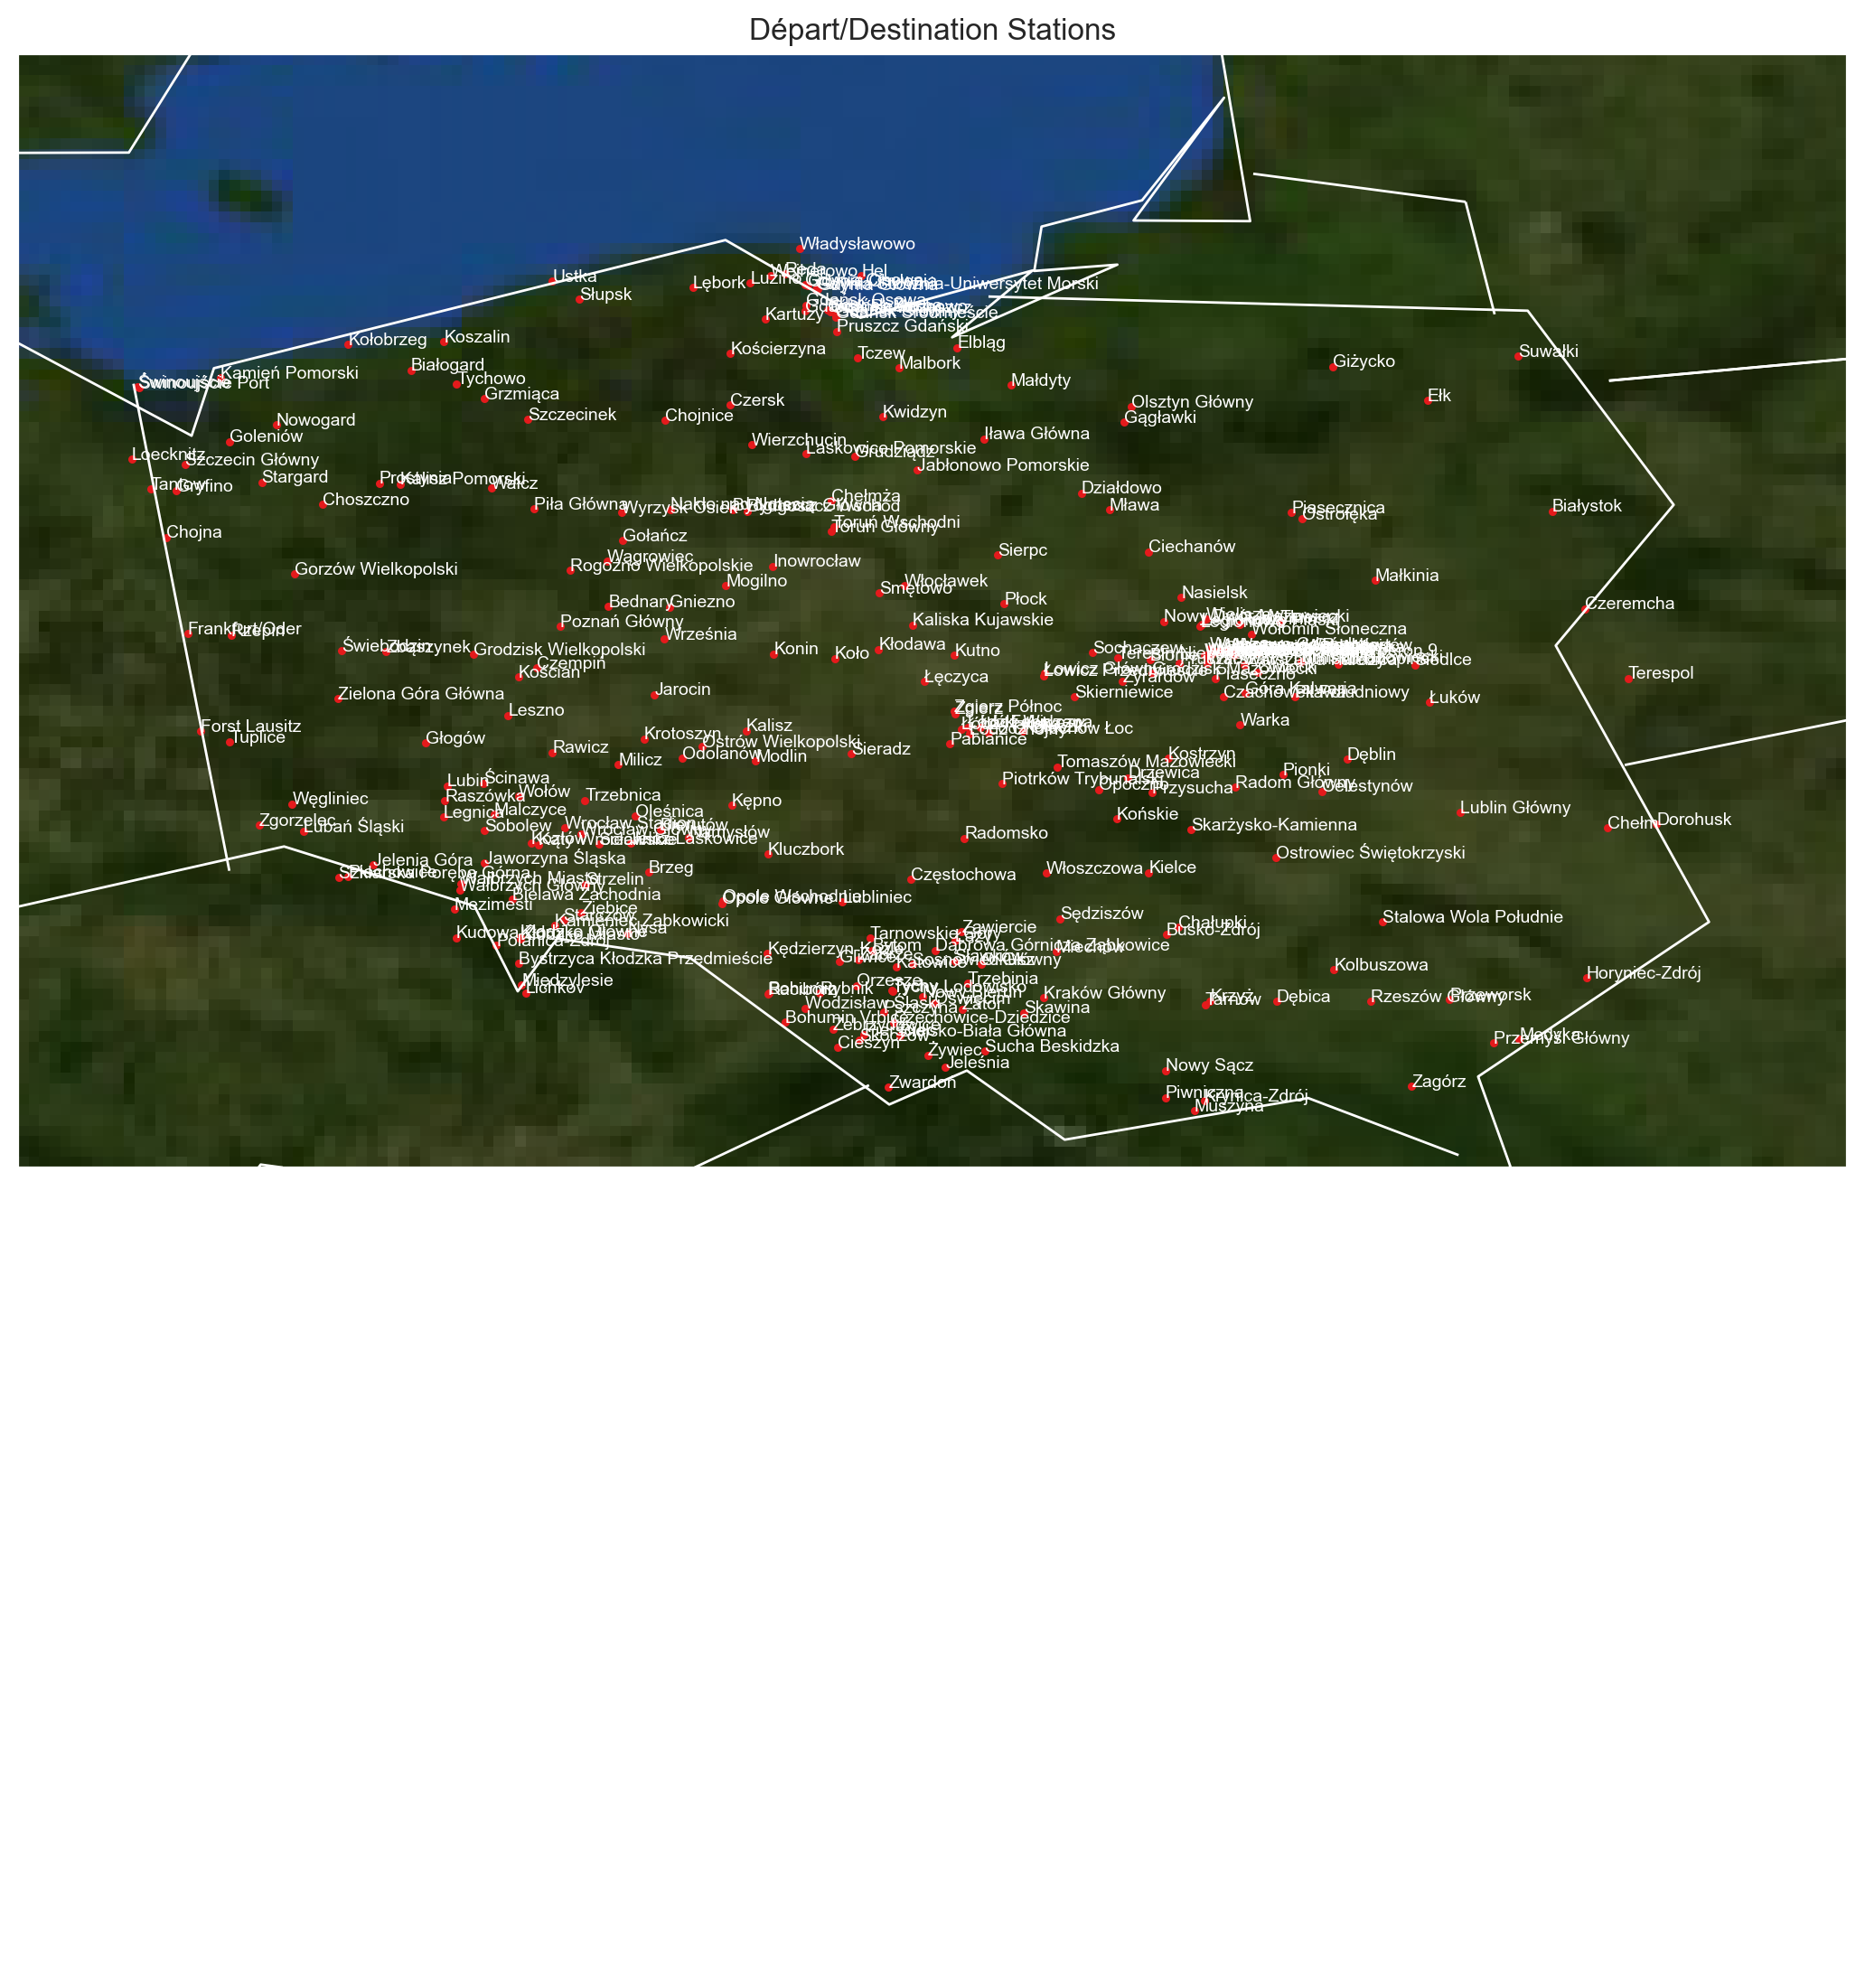

In [15]:
plt.rcParams["figure.figsize"] = (15,8)

m=Basemap(llcrnrlon=13.5, llcrnrlat=49, urcrnrlon=25, urcrnrlat=56)
m.drawcoastlines(linewidth=1, color="white")
m.drawcountries(linewidth=1, color="white")
m.bluemarble()
 
# Add a point per country
for i in gare_loc.keys():
    tx=i,
    m.scatter(
        x=gare_loc[i][0], 
        y=gare_loc[i][1], 
        c=1,
        s=5,
        alpha=1, 
        cmap="Set1"
    )
    plt.text(gare_loc[i][0], gare_loc[i][1], i,fontsize=7,color='w')

plt.title("Départ/Destination Stations")

#### Weather

In [16]:
big_city=pd.read_html("https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Poland")[0]["Name"].to_list()
big_city=[i.split('(', 1)[0] for i in big_city]
big_loc=get_loc(big_city)

del big_loc["Grudziądz"]
del big_loc["Świdnica"]
del big_loc["Włocławek"]
del big_loc["Gniezno"]
del big_loc["Ostrowiec Świętokrzyski"]
del big_loc["Chełm"]
del big_loc["Bydgoszcz"]
del big_loc["Ełk"]
del big_loc["Wałbrzych"]
del big_loc["Inowrocław"]
del big_loc["Głogów"]

In [17]:
start = datetime(2022, 5, 16)
end = datetime(2022, 5, 30)

weather_gare={}
weather_gare_all=pd.DataFrame()

for i in gare_loc:

    point = Point(gare_loc[i][1],gare_loc[i][0])
    data = Daily(point, start, end)
    data = data.fetch()
    if len(data)>0:
        weather_gare[i]=data
        data["gare"]=i
        
        weather_gare_all=pd.concat([weather_gare_all,data])

    else:
        near_city=''
        min=999999999999999999999
        for city,coord in big_loc.items():
            d = distance((gare_loc[i][1],gare_loc[i][0]), (big_loc[city][1],big_loc[city][0])).km
            if d<min:
                min=d
                near_city=city
        point = Point(big_loc[near_city][1],big_loc[near_city][0])
        data = Daily(point, start, end)
        data = data.fetch()
        data["gare"]=i
        weather_gare[i]=data
        weather_gare_all=pd.concat([weather_gare_all, data])
        
weather_gare_all=weather_gare_all.fillna(0)
weather_gare_all=weather_gare_all.reset_index()


In [18]:
weather_gare_all.head()

,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,gare
0,2022-05-16,15.6,4.9,24.5,0.0,0.0,68.0,4.7,14.8,1019.7,0.0,Opole Wschodnie
1,2022-05-17,15.7,11.5,18.5,0.0,0.0,24.0,6.8,22.2,1018.9,0.0,Opole Wschodnie
2,2022-05-18,13.0,6.2,19.6,0.0,0.0,74.0,6.5,16.7,1027.9,0.0,Opole Wschodnie
3,2022-05-19,16.0,3.3,25.5,0.0,0.0,155.0,9.8,27.8,1024.9,0.0,Opole Wschodnie
4,2022-05-20,21.6,14.3,28.4,0.0,0.0,217.0,8.9,29.6,1018.3,0.0,Opole Wschodnie


In [19]:
weather_gare_all["time"]=weather_gare_all["time"].astype('datetime64[ns]')
df["full_day"]=df["save_datetime"].dt.strftime('%Y-%m-%d').astype('datetime64[ns]')


In [20]:
df=df.merge(weather_gare_all, left_on=["full_day",'depart'], right_on=["time",'gare'])
df=df.drop(columns=['gare', 'time'])


df=df.merge(weather_gare_all, left_on=["full_day",'destination'], right_on=["time",'gare'],suffixes=('', '_d'))
df=df.drop(columns=['gare', 'time'])

df.head()

,save_datetime,id_train_complet,transporteur,date_depart,depart_destination,arrivee_prevue,retard,nom_station,id_train,index_part1,index_part2,index_part3,depart,destination,full_day,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,tavg_d,tmin_d,tmax_d,prcp_d,snow_d,wdir_d,wspd_d,wpgt_d,pres_d,tsun_d
0,2022-05-16 00:00:00,95697,PKP SKM w Trójmieście Sp. z o.o.,2022-05-15,Gdańsk Zaspa - Wejherowo,23:38:00,24,Reda Pieleszewo,95697,,,,Gdańsk Zaspa,Wejherowo,2022-05-16,11.1,4.0,18.0,0.0,0.0,340.0,11.0,27.8,1020.3,0.0,11.1,4.0,18.0,0.0,0.0,340.0,11.0,27.8,1020.3,0.0
1,2022-05-16 00:05:00,95697,PKP SKM w Trójmieście Sp. z o.o.,2022-05-15,Gdańsk Zaspa - Wejherowo,23:47:00,23,Wejherowo,95697,,,,Gdańsk Zaspa,Wejherowo,2022-05-16,11.1,4.0,18.0,0.0,0.0,340.0,11.0,27.8,1020.3,0.0,11.1,4.0,18.0,0.0,0.0,340.0,11.0,27.8,1020.3,0.0
2,2022-05-16 00:05:00,95697,PKP SKM w Trójmieście Sp. z o.o.,2022-05-15,Gdańsk Zaspa - Wejherowo,23:41:00,24,Wejherowo Śmiechowo,95697,,,,Gdańsk Zaspa,Wejherowo,2022-05-16,11.1,4.0,18.0,0.0,0.0,340.0,11.0,27.8,1020.3,0.0,11.1,4.0,18.0,0.0,0.0,340.0,11.0,27.8,1020.3,0.0
3,2022-05-16 00:05:00,95697,PKP SKM w Trójmieście Sp. z o.o.,2022-05-15,Gdańsk Zaspa - Wejherowo,23:44:00,23,Wejherowo-Nanice,95697,,,,Gdańsk Zaspa,Wejherowo,2022-05-16,11.1,4.0,18.0,0.0,0.0,340.0,11.0,27.8,1020.3,0.0,11.1,4.0,18.0,0.0,0.0,340.0,11.0,27.8,1020.3,0.0
4,2022-05-16 00:35:00,95699,PKP SKM w Trójmieście Sp. z o.o.,2022-05-16,Gdańsk Zaspa - Wejherowo,00:34:00,3,Reda Pieleszewo,95699,,,,Gdańsk Zaspa,Wejherowo,2022-05-16,11.1,4.0,18.0,0.0,0.0,340.0,11.0,27.8,1020.3,0.0,11.1,4.0,18.0,0.0,0.0,340.0,11.0,27.8,1020.3,0.0


### Classico

In [21]:
df['day']=df["save_datetime"].dt.day
df['dayofweek_num']=df["save_datetime"].dt.dayofweek  
df['hour'] = df["save_datetime"].dt.hour 
df['minute'] = df["save_datetime"].dt.minute

### Passage dans station durant une journée

#### Nombre de passages dans cette station de train durant la journée/heure

In [22]:
df['all_passa_station_d'] = df.groupby(["day","nom_station"]).cumcount()
df['all_passa_station_h'] = df.groupby(["hour","nom_station"]).cumcount()

#### Nombre de passages dans cette station pour cet id train durant journée

In [23]:
df['passa_station'] = df.groupby(["id_train","day","nom_station"]).cumcount()

#### Nombre de stop durant journée

In [24]:
df['stop'] = df.groupby(["id_train","day"]).cumcount()

### Last Station 

#### identification

In [25]:
df=df.sort_values(by=["id_train","save_datetime","arrivee_prevue"])
df['last_station'] = df['nom_station'].shift(1)
df['last_station_2'] = df['nom_station'].shift(2)
df['last_station_3'] = df['nom_station'].shift(3)

In [26]:
df['last_station']= np.where(df['id_train'].shift(1) == df['id_train'], df['nom_station'].shift(1) , None)
df['last_station_2']= np.where(df['id_train'].shift(2) == df['id_train'], df['nom_station'].shift(2) , None)
df['last_station_3']= np.where(df['id_train'].shift(3) == df['id_train'], df['nom_station'].shift(3) , None)

####  retard moyen dans les gares avec fenêtre roulante

In [27]:
df['mean_retard_station_r']=df[df['nom_station']==df['nom_station'].astype(str)]['retard'].rolling(window=5).mean() 
df['mean_retard_last_station_1_r']=df[df['last_station']==df['last_station'].astype(str)]['retard'].rolling(window=5).mean()
df['mean_retard_last_station_2_r']=df[df['last_station_2']==df['last_station_2'].astype(str)]['retard'].rolling(window=5).mean()
df['mean_retard_last_station_3_r']=df[df['last_station_3']==df['last_station_3'].astype(str)]['retard'].rolling(window=5).mean()


####  retard moyen dans les gares avec fenêtre expansive

In [28]:
df['mean_retard_station_e']=df[df['nom_station']==df['nom_station'].astype(str)]['retard'].expanding(2).mean()
df['mean_retard_last_station_1_e']=df[df['last_station']==df['last_station'].astype(str)]['retard'].expanding(2).mean()
df['mean_retard_last_station_2_e']=df[df['last_station_2']==df['last_station_2'].astype(str)]['retard'].expanding(2).mean()
df['mean_retard_last_station_3_e']=df[df['last_station_3']==df['last_station_3'].astype(str)]['retard'].expanding(2).mean()

####  retard  dans les gares 

In [29]:
df['retard_last_station_1']=np.where(df['id_train'].shift(1) == df['id_train'], df['retard'].shift(1) , None)
df['retard_last_station_2']=np.where(df['id_train'].shift(2) == df['id_train'], df['retard'].shift(2) , None)
df['retard_last_station_3']=np.where(df['id_train'].shift(3) == df['id_train'], df['retard'].shift(3) , None)

#### distance geo

In [30]:
combi=df[["nom_station","last_station"]].drop_duplicates(["nom_station","last_station"])
combi2=df[["nom_station","last_station_2"]].drop_duplicates(["nom_station","last_station_2"]).rename(columns={"last_station_2": "last_station"})
combi3=df[["nom_station","last_station_3"]].drop_duplicates(["nom_station","last_station_3"]).rename(columns={"last_station_3": "last_station"})

all_combi=pd.concat([combi,combi2])
all_combi=pd.concat([all_combi,combi3]).drop_duplicates(["nom_station","last_station"]).dropna()
all_combi=all_combi[all_combi['nom_station']!=all_combi['last_station']]
station_loc=get_loc(df["nom_station"].unique())

In [31]:
all_combi["dist"]=all_combi.apply(lambda x: distance((station_loc[x["nom_station"]][1],
                                       station_loc[x["nom_station"]][0]),
                                      (station_loc[x["last_station"]][1],
                                       station_loc[x["last_station"]][0])).km, axis=1)

all_combi.head()

,nom_station,last_station,dist
9165,Warszawa Wschodnia,Warszawa Centralna,4.209189
27733,Warszawa Centralna,Warszawa Wschodnia,4.209189
1137,Warszawa Zachodnia,Warszawa Centralna,2.770721
17307,Warszawa Wschodnia,Warszawa Zachodnia,6.911387
16150,Koluszki,Łódź Widzew,18.504592


In [32]:
df=pd.merge(df, all_combi,  how='left', left_on=['nom_station','last_station'], right_on = ['nom_station','last_station'])
all_combi=all_combi.rename(columns={"last_station": "last_station_2","dist":"dist_2"})
df=pd.merge(df, all_combi,  how='left', left_on=['nom_station','last_station_2'], right_on = ['nom_station','last_station_2'])
all_combi=all_combi.rename(columns={"last_station_2": "last_station_3","dist_2":"dist_3"})
df=pd.merge(df, all_combi,  how='left', left_on=['nom_station','last_station_3'], right_on = ['nom_station','last_station_3'])

#### distance temps minutes

In [33]:
df['delai_last']=np.where(df['id_train'].shift(1) == df['id_train'],
                          (df['save_datetime']-df['save_datetime'].shift(1)).astype('timedelta64[m]'), None)

df['delai_last2']=np.where(df['id_train'].shift(2) == df['id_train'],
                            (df['save_datetime']-df['save_datetime'].shift(2)).astype('timedelta64[m]'),None)
                           
df['delai_last3']=np.where(df['id_train'].shift(3) == df['id_train'],
                            (df['save_datetime']-df['save_datetime'].shift(3)).astype('timedelta64[m]'),None)

In [34]:
len(df)

224446

In [35]:
df.head()

,save_datetime,id_train_complet,transporteur,date_depart,depart_destination,arrivee_prevue,retard,nom_station,id_train,index_part1,index_part2,index_part3,depart,destination,full_day,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,tavg_d,tmin_d,tmax_d,prcp_d,snow_d,wdir_d,wspd_d,wpgt_d,pres_d,tsun_d,day,dayofweek_num,hour,minute,all_passa_station_d,all_passa_station_h,passa_station,stop,last_station,last_station_2,last_station_3,mean_retard_station_r,mean_retard_last_station_1_r,mean_retard_last_station_2_r,mean_retard_last_station_3_r,mean_retard_station_e,mean_retard_last_station_1_e,mean_retard_last_station_2_e,mean_retard_last_station_3_e,retard_last_station_1,retard_last_station_2,retard_last_station_3,dist,dist_2,dist_3,delai_last,delai_last2,delai_last3
0,2022-05-16 20:25:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-16,Warszawa Zachodnia - Białystok,20:18:00,8,Warszawa Centralna,10102,/3,,ZAMENHOF,Warszawa Zachodnia,Białystok,2022-05-16,14.5,8.4,19.3,0.0,0.0,345.0,8.4,22.2,1020.3,0.0,11.5,3.9,17.9,0.0,0.0,324.0,6.6,25.9,1019.9,0.0,16,0,20,25,108,6,0,0,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN,NaN,None,None,None
1,2022-05-16 20:30:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-16,Warszawa Zachodnia - Białystok,20:30:00,7,Warszawa Wschodnia,10102,/3,,ZAMENHOF,Warszawa Zachodnia,Białystok,2022-05-16,14.5,8.4,19.3,0.0,0.0,345.0,8.4,22.2,1020.3,0.0,11.5,3.9,17.9,0.0,0.0,324.0,6.6,25.9,1019.9,0.0,16,0,20,30,465,22,0,1,Warszawa Centralna,None,None,NaN,NaN,NaN,NaN,7.50,NaN,NaN,NaN,8.0,None,None,4.209189,NaN,NaN,5.0,None,None
2,2022-05-17 20:15:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-17,Warszawa Zachodnia - Białystok,20:18:00,0,Warszawa Centralna,10102,/3,,ZAMENHOF,Warszawa Zachodnia,Białystok,2022-05-17,13.3,9.0,18.1,0.0,0.0,12.0,17.9,38.9,1020.8,0.0,9.4,4.2,14.7,0.0,0.0,337.0,11.4,40.8,1020.7,0.0,17,1,20,15,147,19,0,0,Warszawa Wschodnia,Warszawa Centralna,None,NaN,NaN,NaN,NaN,5.00,3.500000,NaN,NaN,7.0,8.0,None,4.209189,NaN,NaN,1425.0,1430.0,None
3,2022-05-17 20:25:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-17,Warszawa Zachodnia - Białystok,20:30:00,0,Warszawa Wschodnia,10102,/3,,ZAMENHOF,Warszawa Zachodnia,Białystok,2022-05-17,13.3,9.0,18.1,0.0,0.0,12.0,17.9,38.9,1020.8,0.0,9.4,4.2,14.7,0.0,0.0,337.0,11.4,40.8,1020.7,0.0,17,1,20,25,488,56,0,1,Warszawa Centralna,Warszawa Wschodnia,Warszawa Centralna,NaN,NaN,NaN,NaN,3.75,2.333333,0.0,NaN,0.0,7.0,8.0,4.209189,NaN,4.209189,10.0,1435.0,1440.0
4,2022-05-18 20:15:00,10102/3 ZAMENHOF,PKP Intercity,2022-05-18,Warszawa Zachodnia - Białystok,20:18:00,0,Warszawa Centralna,10102,/3,,ZAMENHOF,Warszawa Zachodnia,Białystok,2022-05-18,11.2,2.9,18.5,0.0,0.0,311.0,11.1,35.2,1027.8,0.0,9.6,2.5,16.8,0.0,0.0,325.0,9.5,24.1,1026.7,0.0,18,2,20,15,125,30,0,0,Warszawa Wschodnia,Warszawa Centralna,Warszawa Wschodnia,3.0,NaN,NaN,NaN,3.00,1.750000,0.0,0.0,0.0,0.0,7.0,4.209189,NaN,4.209189,1430.0,1440.0,2865.0


In [36]:
df.columns.tolist()

['save_datetime',
 'id_train_complet',
 'transporteur',
 'date_depart',
 'depart_destination',
 'arrivee_prevue',
 'retard',
 'nom_station',
 'id_train',
 'index_part1',
 'index_part2',
 'index_part3',
 'depart',
 'destination',
 'full_day',
 'tavg',
 'tmin',
 'tmax',
 'prcp',
 'snow',
 'wdir',
 'wspd',
 'wpgt',
 'pres',
 'tsun',
 'tavg_d',
 'tmin_d',
 'tmax_d',
 'prcp_d',
 'snow_d',
 'wdir_d',
 'wspd_d',
 'wpgt_d',
 'pres_d',
 'tsun_d',
 'day',
 'dayofweek_num',
 'hour',
 'minute',
 'all_passa_station_d',
 'all_passa_station_h',
 'passa_station',
 'stop',
 'last_station',
 'last_station_2',
 'last_station_3',
 'mean_retard_station_r',
 'mean_retard_last_station_1_r',
 'mean_retard_last_station_2_r',
 'mean_retard_last_station_3_r',
 'mean_retard_station_e',
 'mean_retard_last_station_1_e',
 'mean_retard_last_station_2_e',
 'mean_retard_last_station_3_e',
 'retard_last_station_1',
 'retard_last_station_2',
 'retard_last_station_3',
 'dist',
 'dist_2',
 'dist_3',
 'delai_last',
 'delai_

# Data visualisation : 

# Exploration des données : 

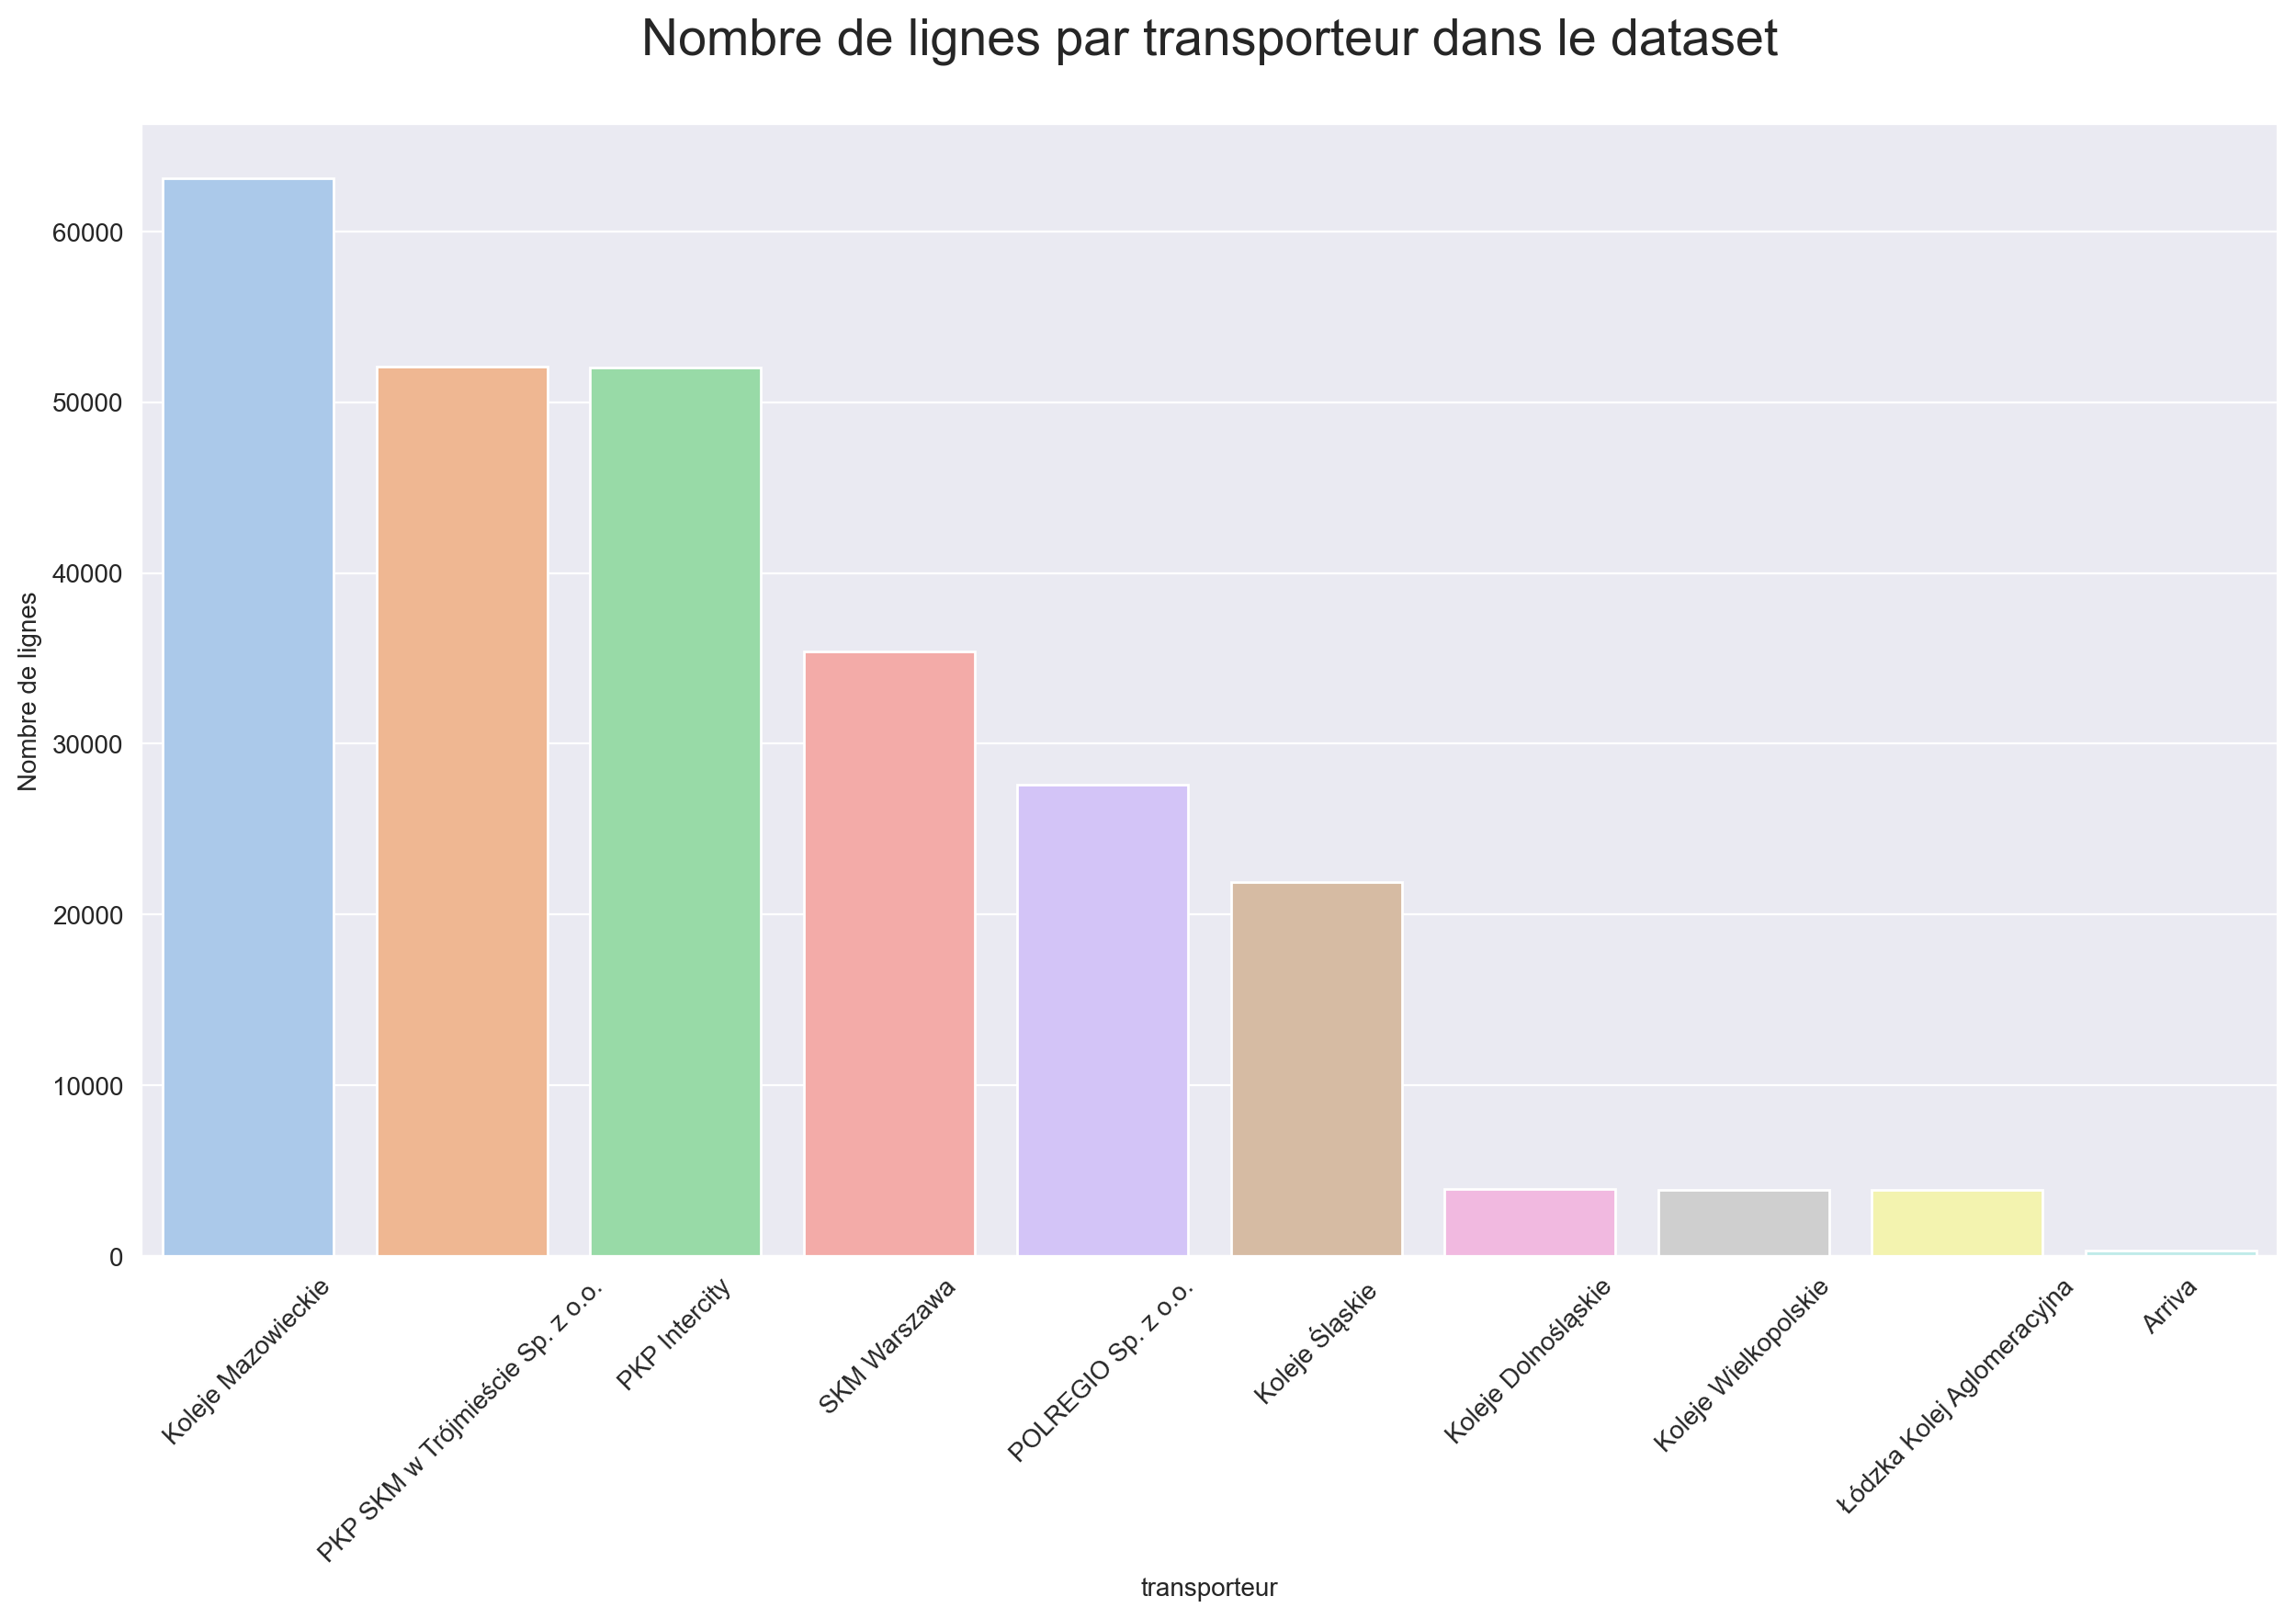

In [178]:
sns.barplot(data=df.groupby("transporteur").agg("count").sort_values("id_train_complet",ascending=False).rename(columns={"id_train_complet":"Nombre de lignes"}).reset_index(), 
            x="transporteur",
            y="Nombre de lignes")
plt.title("Nombre de lignes par transporteur dans le dataset\n",fontsize=20)
plt.xticks(rotation=45)
plt.show()

In [180]:
#Nombre moyen de lignes enregistrées toutes les 5 minutes 
df.groupby("datetime_save").agg("count").mean()

id_train_complet      65.641402
transporteur          65.641402
date_depart           65.641402
depart_destination    65.641402
arrivee_prevue        65.641402
retard                65.641402
nom_station           65.641402
id_train              65.641402
index_part1           65.641402
index_part2           65.641402
index_part3           65.641402
depart                65.641402
destination           65.641402
travel                65.641402
num_station           65.641402
dtype: float64

In [180]:
df[(df["id_train"]=='10102/3  ZAMENHOF')  & (df["datetime_save"]==datetime.strptime('2022-05-17 20:10:00','%Y-%m-%d %H:%M:%S'))]

,id_train,transporteur,trajet,depart,destination,date_depart,horaire_arrivee,datetime_save,last_station,retard_prevu,heure_arrivee,min_arrivee
517008,10102/3 ZAMENHOF,PKP Intercity,Warszawa Zachodnia - Białystok,Warszawa Zachodnia,Białystok,2022-05-17,20:18,2022-05-17 20:10:00,Warszawa Centralna,0,20,18
517180,10102/3 ZAMENHOF,PKP Intercity,Warszawa Zachodnia - Białystok,Warszawa Zachodnia,Białystok,2022-05-17,20:30,2022-05-17 20:10:00,Warszawa Wschodnia,0,20,30


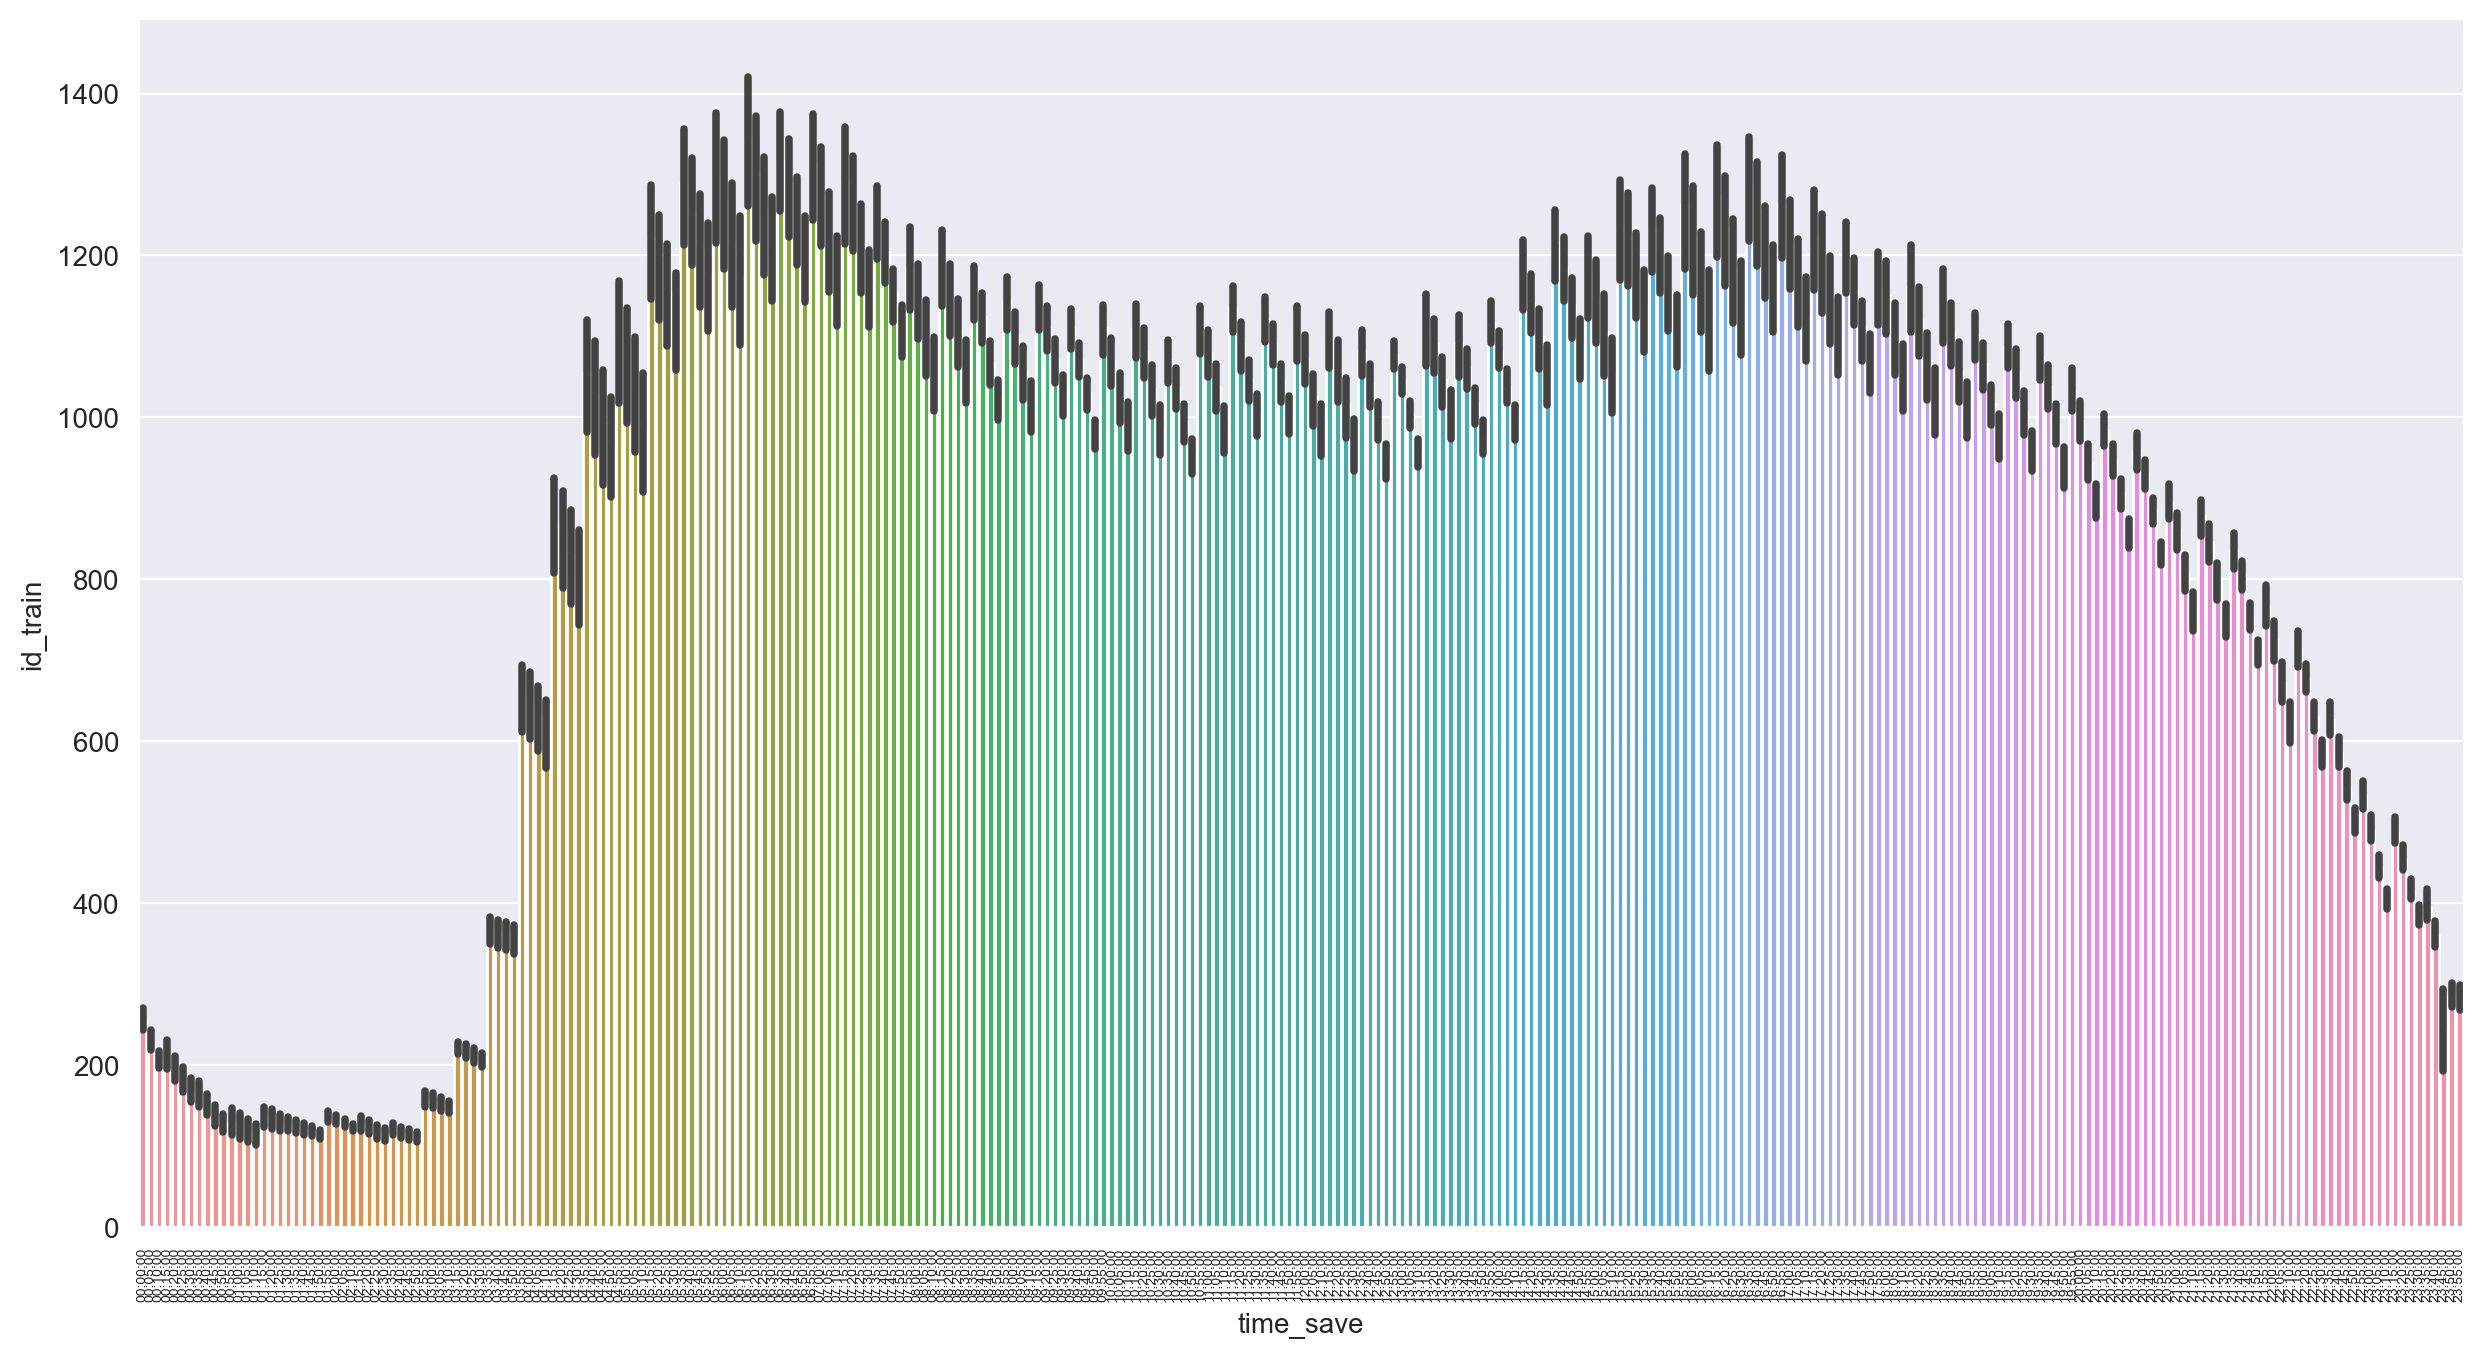

In [211]:
df_temp =df.copy(deep=True)
df_temp["date_save"]=df_temp["datetime_save"].dt.date
df_temp["time_save"]=df_temp["datetime_save"].dt.time

sns.barplot(data=df_temp.groupby(["date_save","time_save"]).agg("count").reset_index().sort_values("time_save"),
           x="time_save",y="id_train")
plt.xticks(rotation=90, fontsize=5)
plt.show()

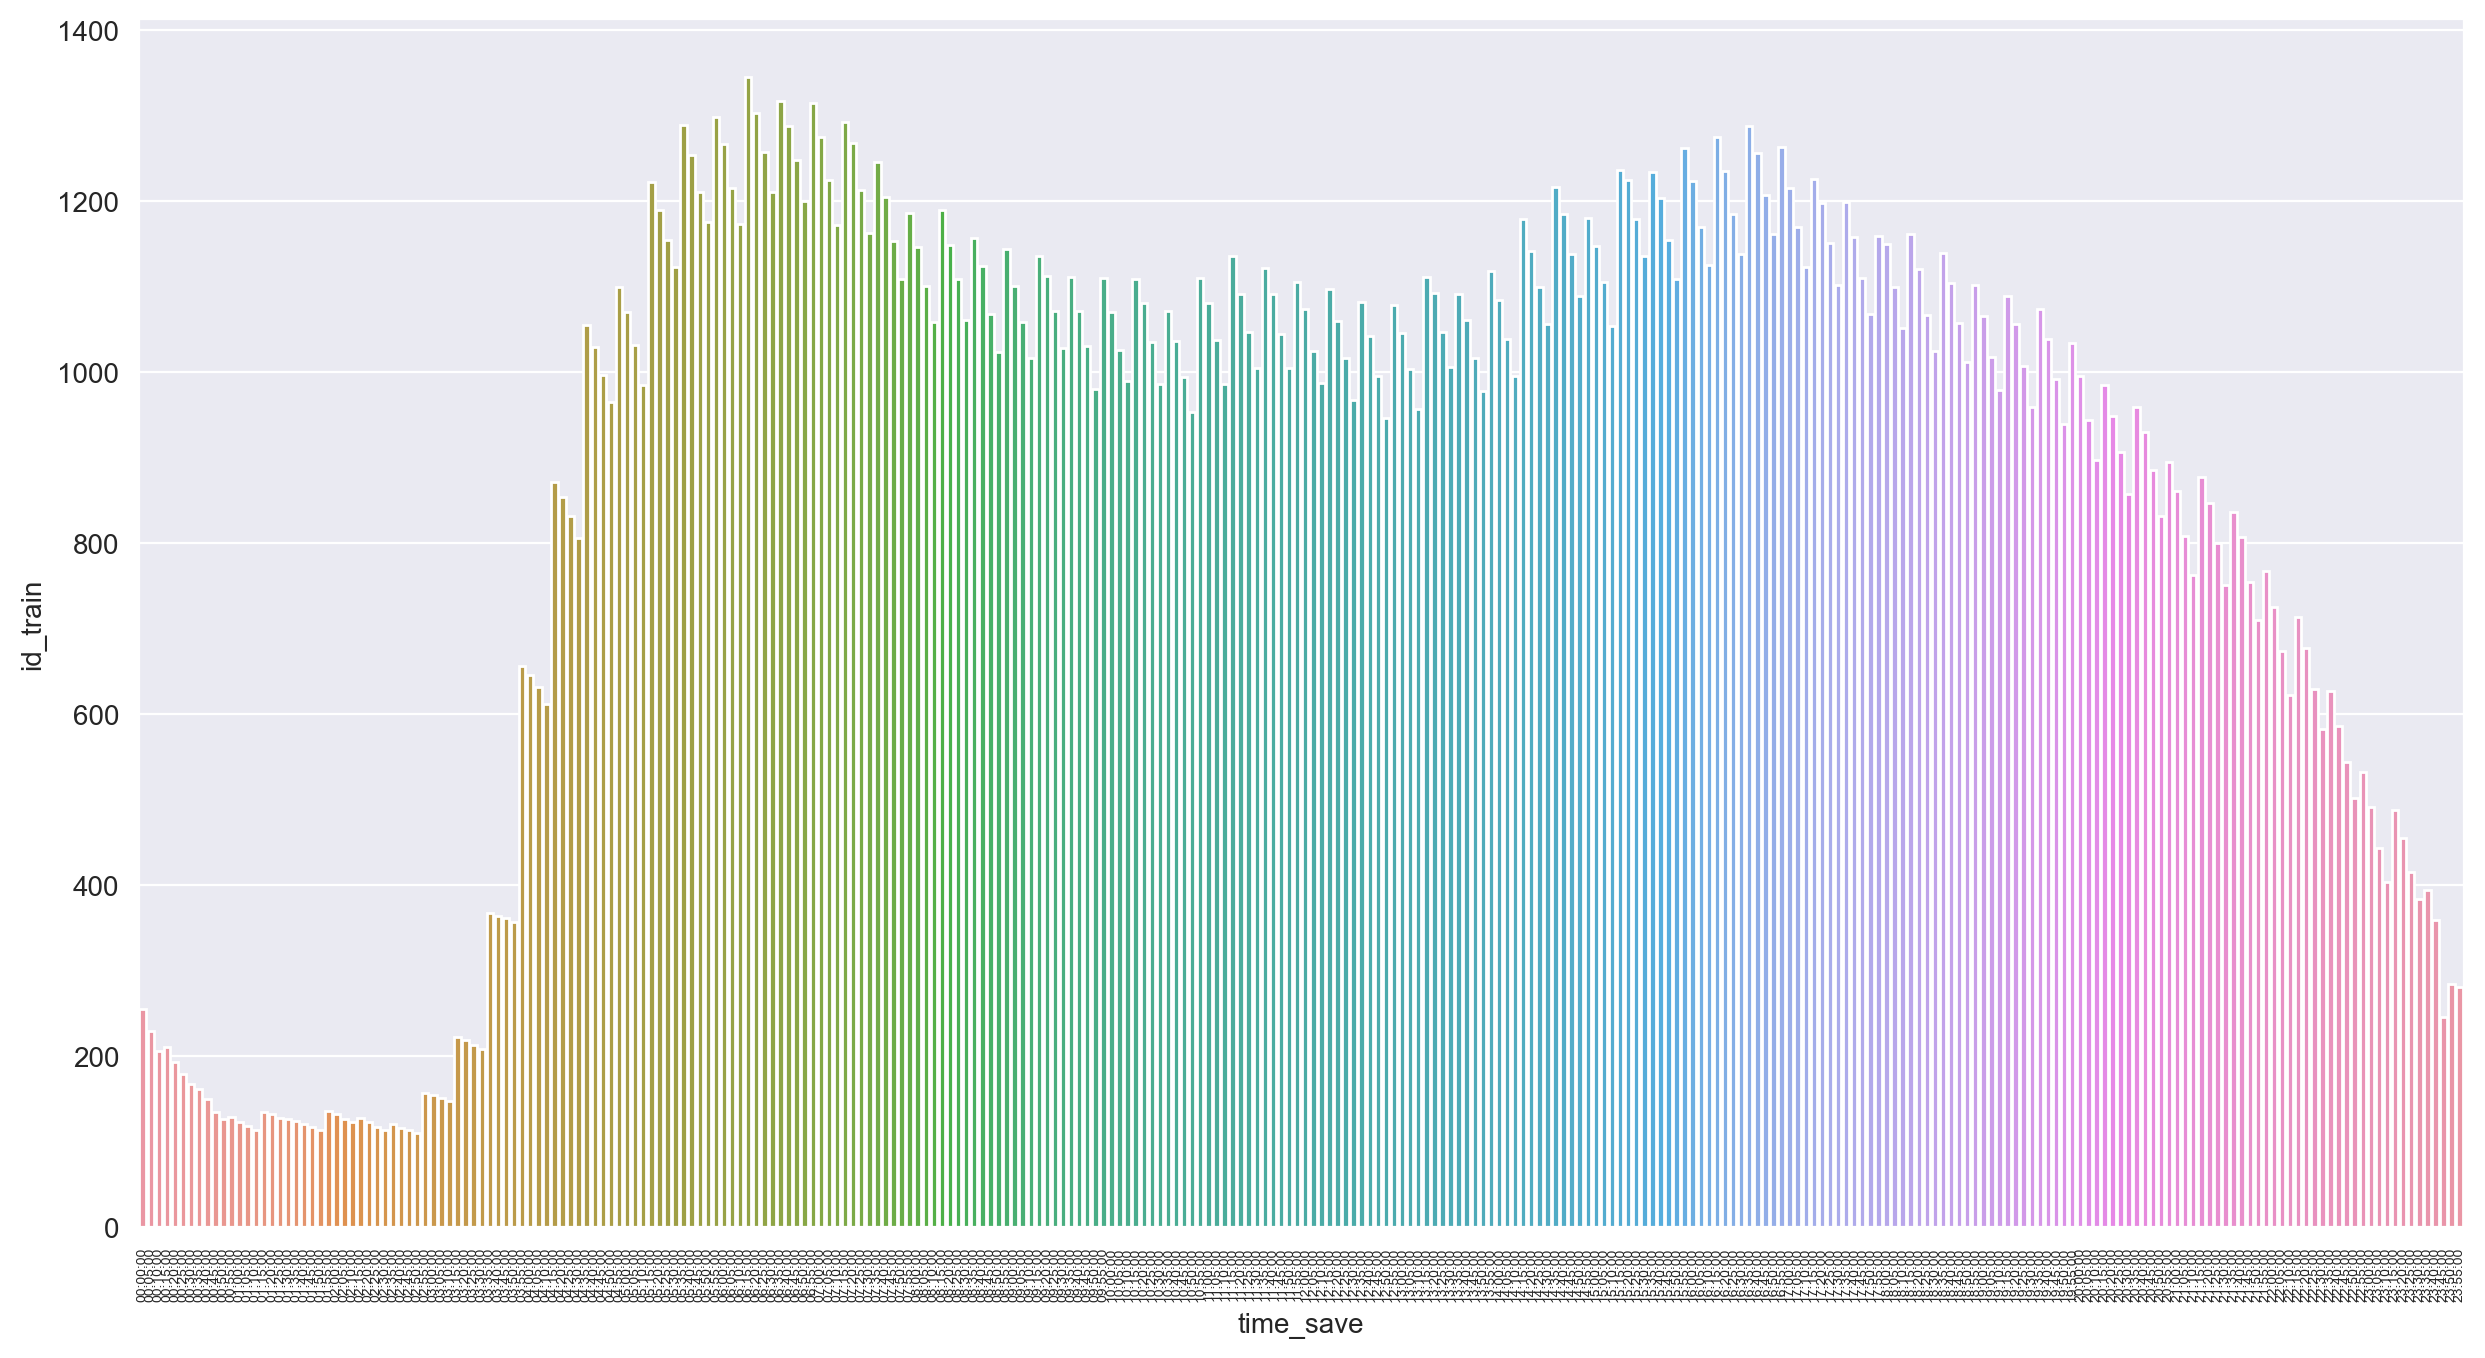

In [207]:
df_temp =df.copy(deep=True)
df_temp["date_save"]=df_temp["datetime_save"].dt.date
df_temp["time_save"]=df_temp["datetime_save"].dt.time

sns.barplot(data=df_temp.groupby(["date_save","time_save"]).agg("count").reset_index().groupby("time_save").agg("mean").reset_index().sort_values("time_save"),
           x="time_save",y="id_train")
plt.xticks(rotation=90, fontsize=5)
plt.show()

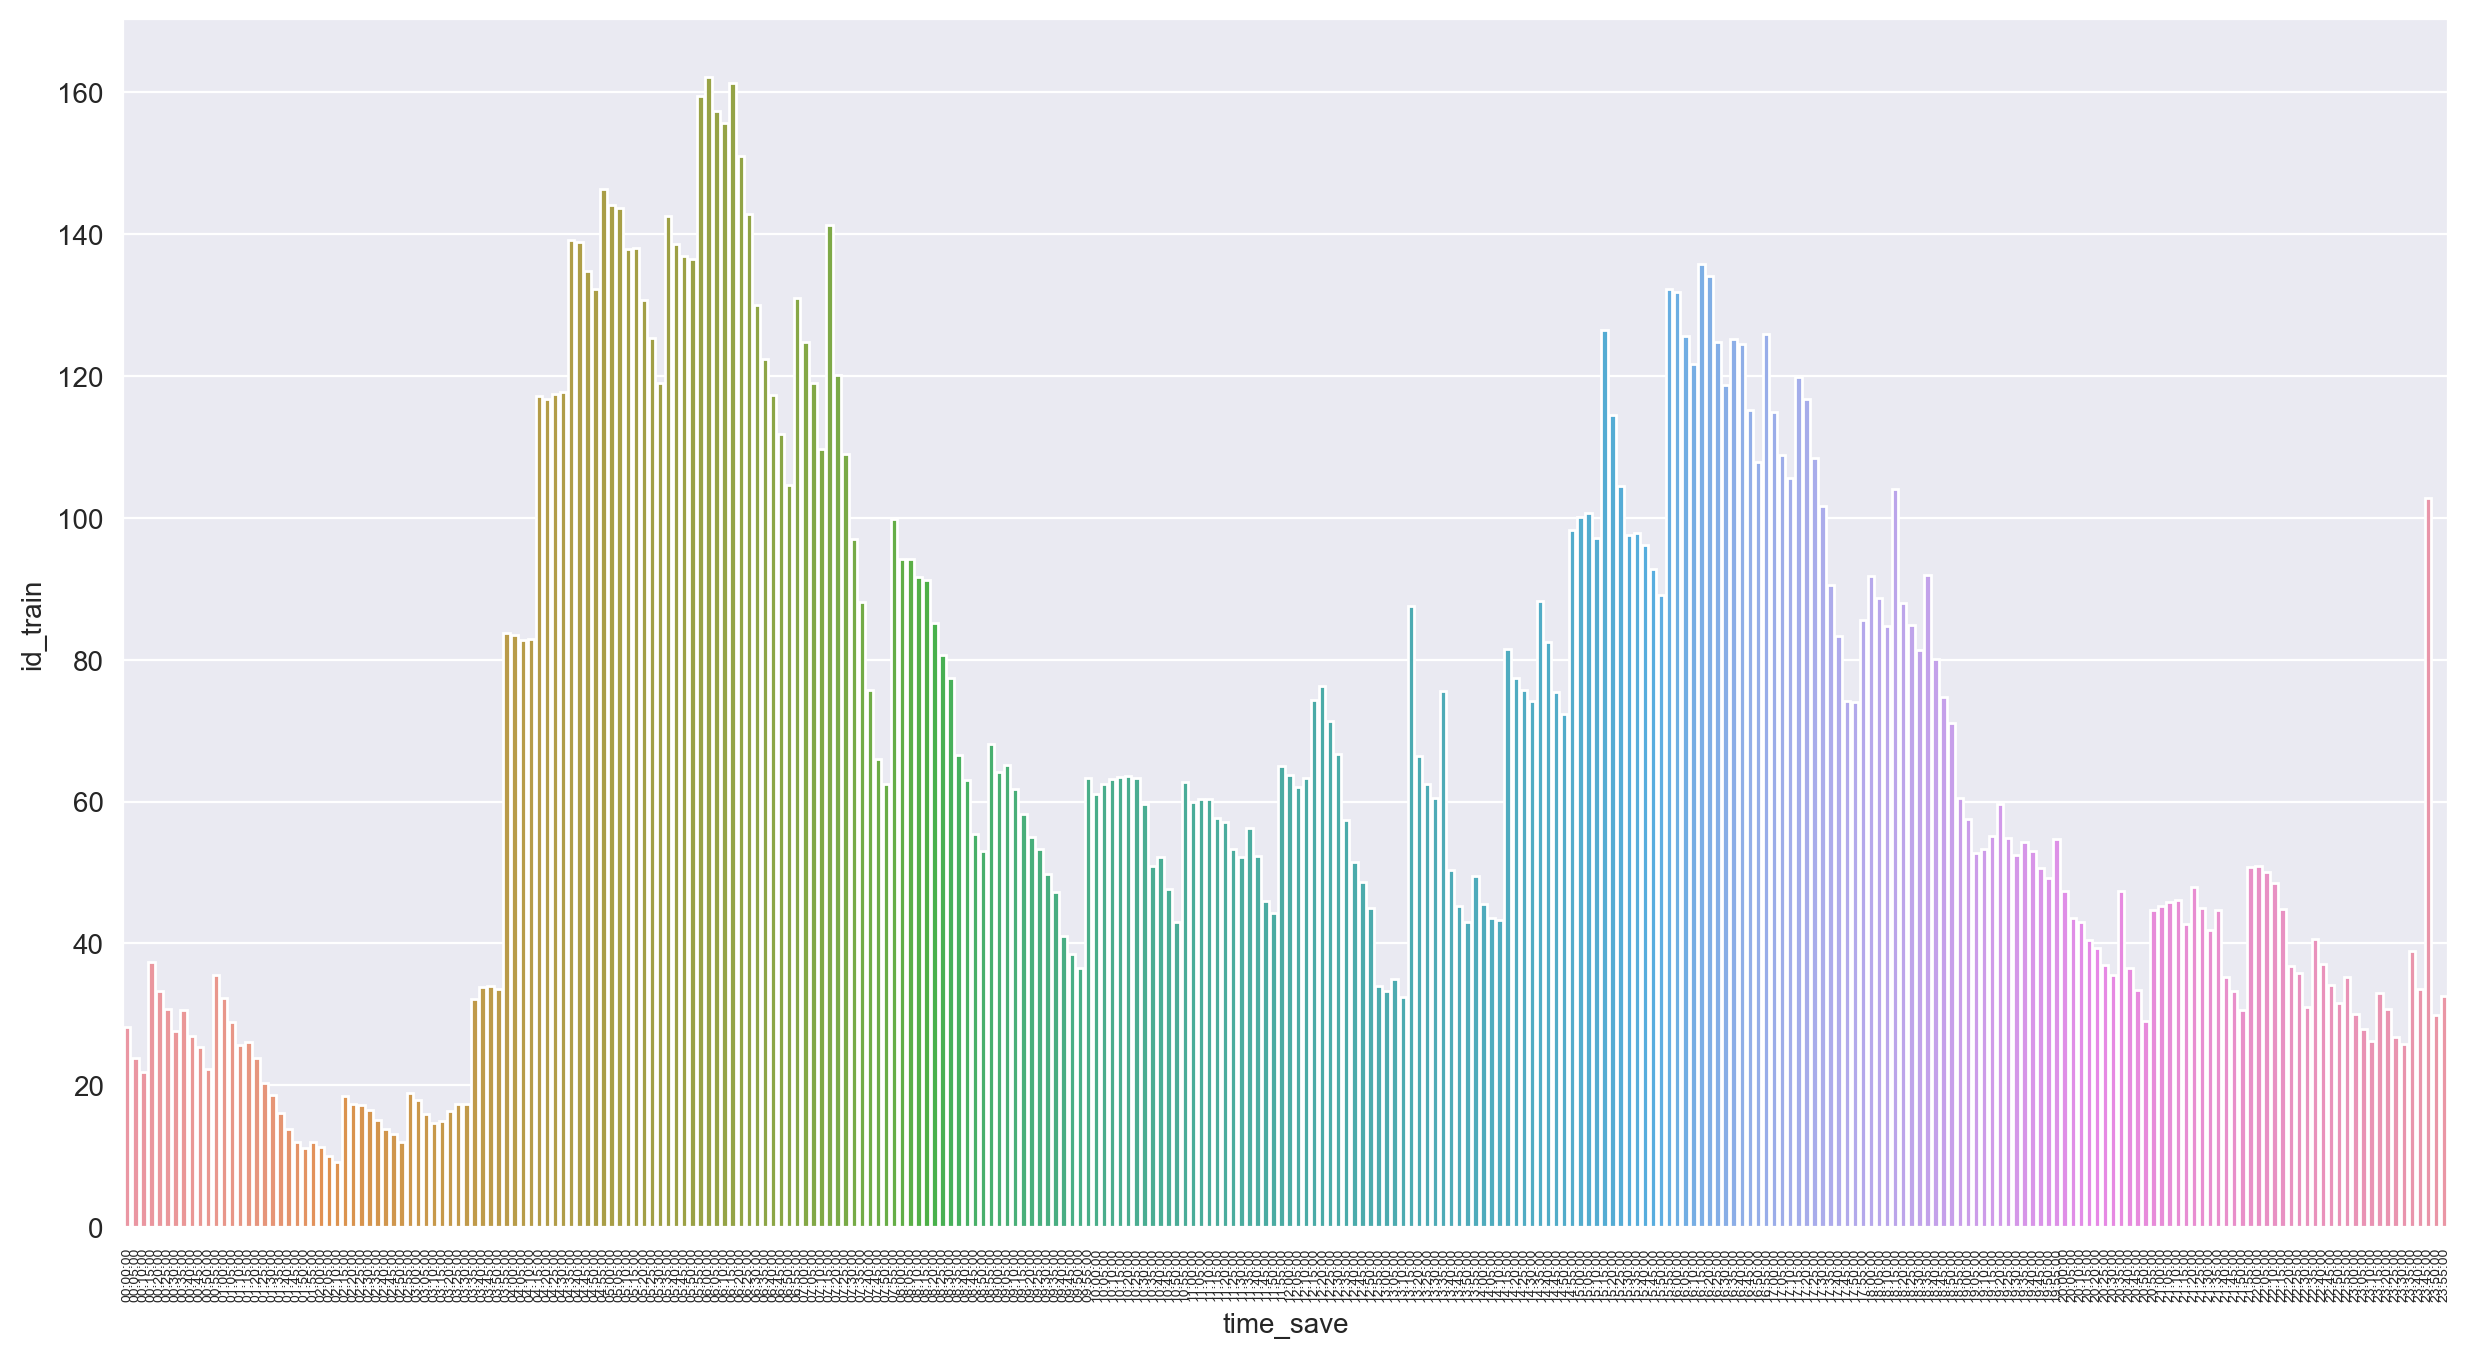

In [204]:
df_temp =df.copy(deep=True)
df_temp["date_save"]=df_temp["datetime_save"].dt.date
df_temp["time_save"]=df_temp["datetime_save"].dt.time

sns.barplot(data=df_temp.groupby(["date_save","time_save"]).agg("count").reset_index().groupby("time_save").agg("std").reset_index().sort_values("time_save"),
           x="time_save",y="id_train")


plt.xticks(rotation=90, fontsize=5)
plt.show()

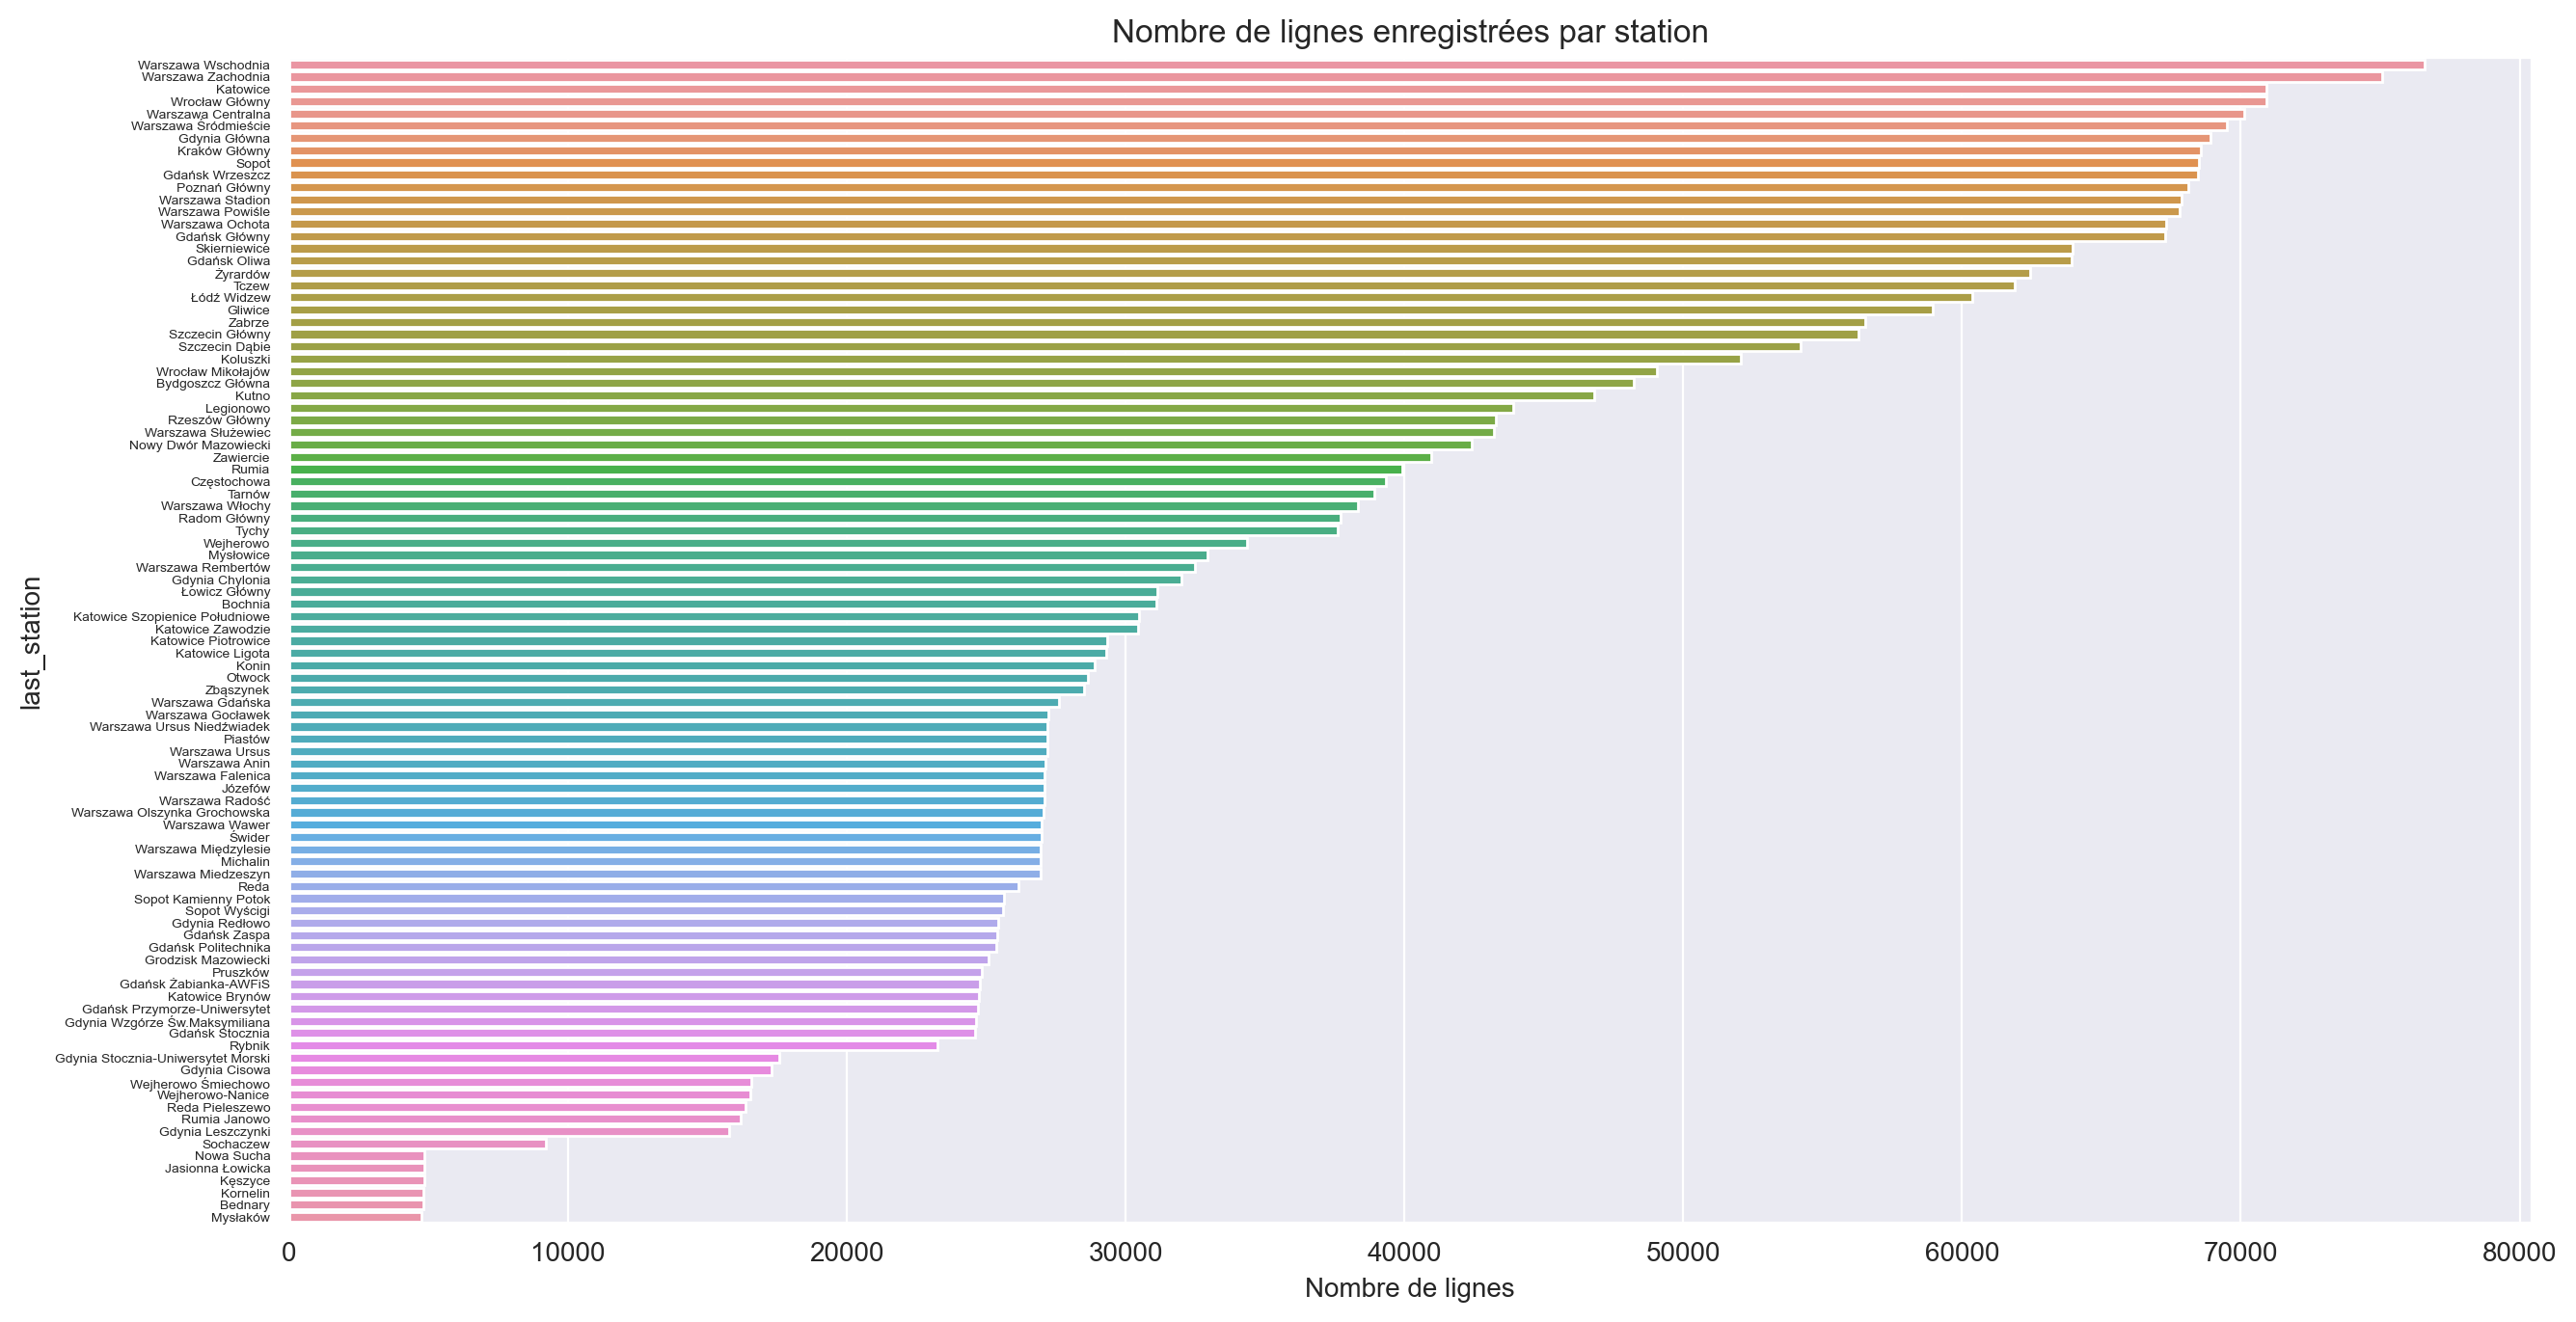

In [222]:
sns.barplot(data=df.groupby(["last_station"]).agg("count").reset_index().sort_values("retard_prevu",ascending=False),x="retard_prevu",y="last_station")

plt.yticks(fontsize=5)
plt.title("Nombre de lignes enregistrées par station")
plt.xlabel("Nombre de lignes")
plt.show()

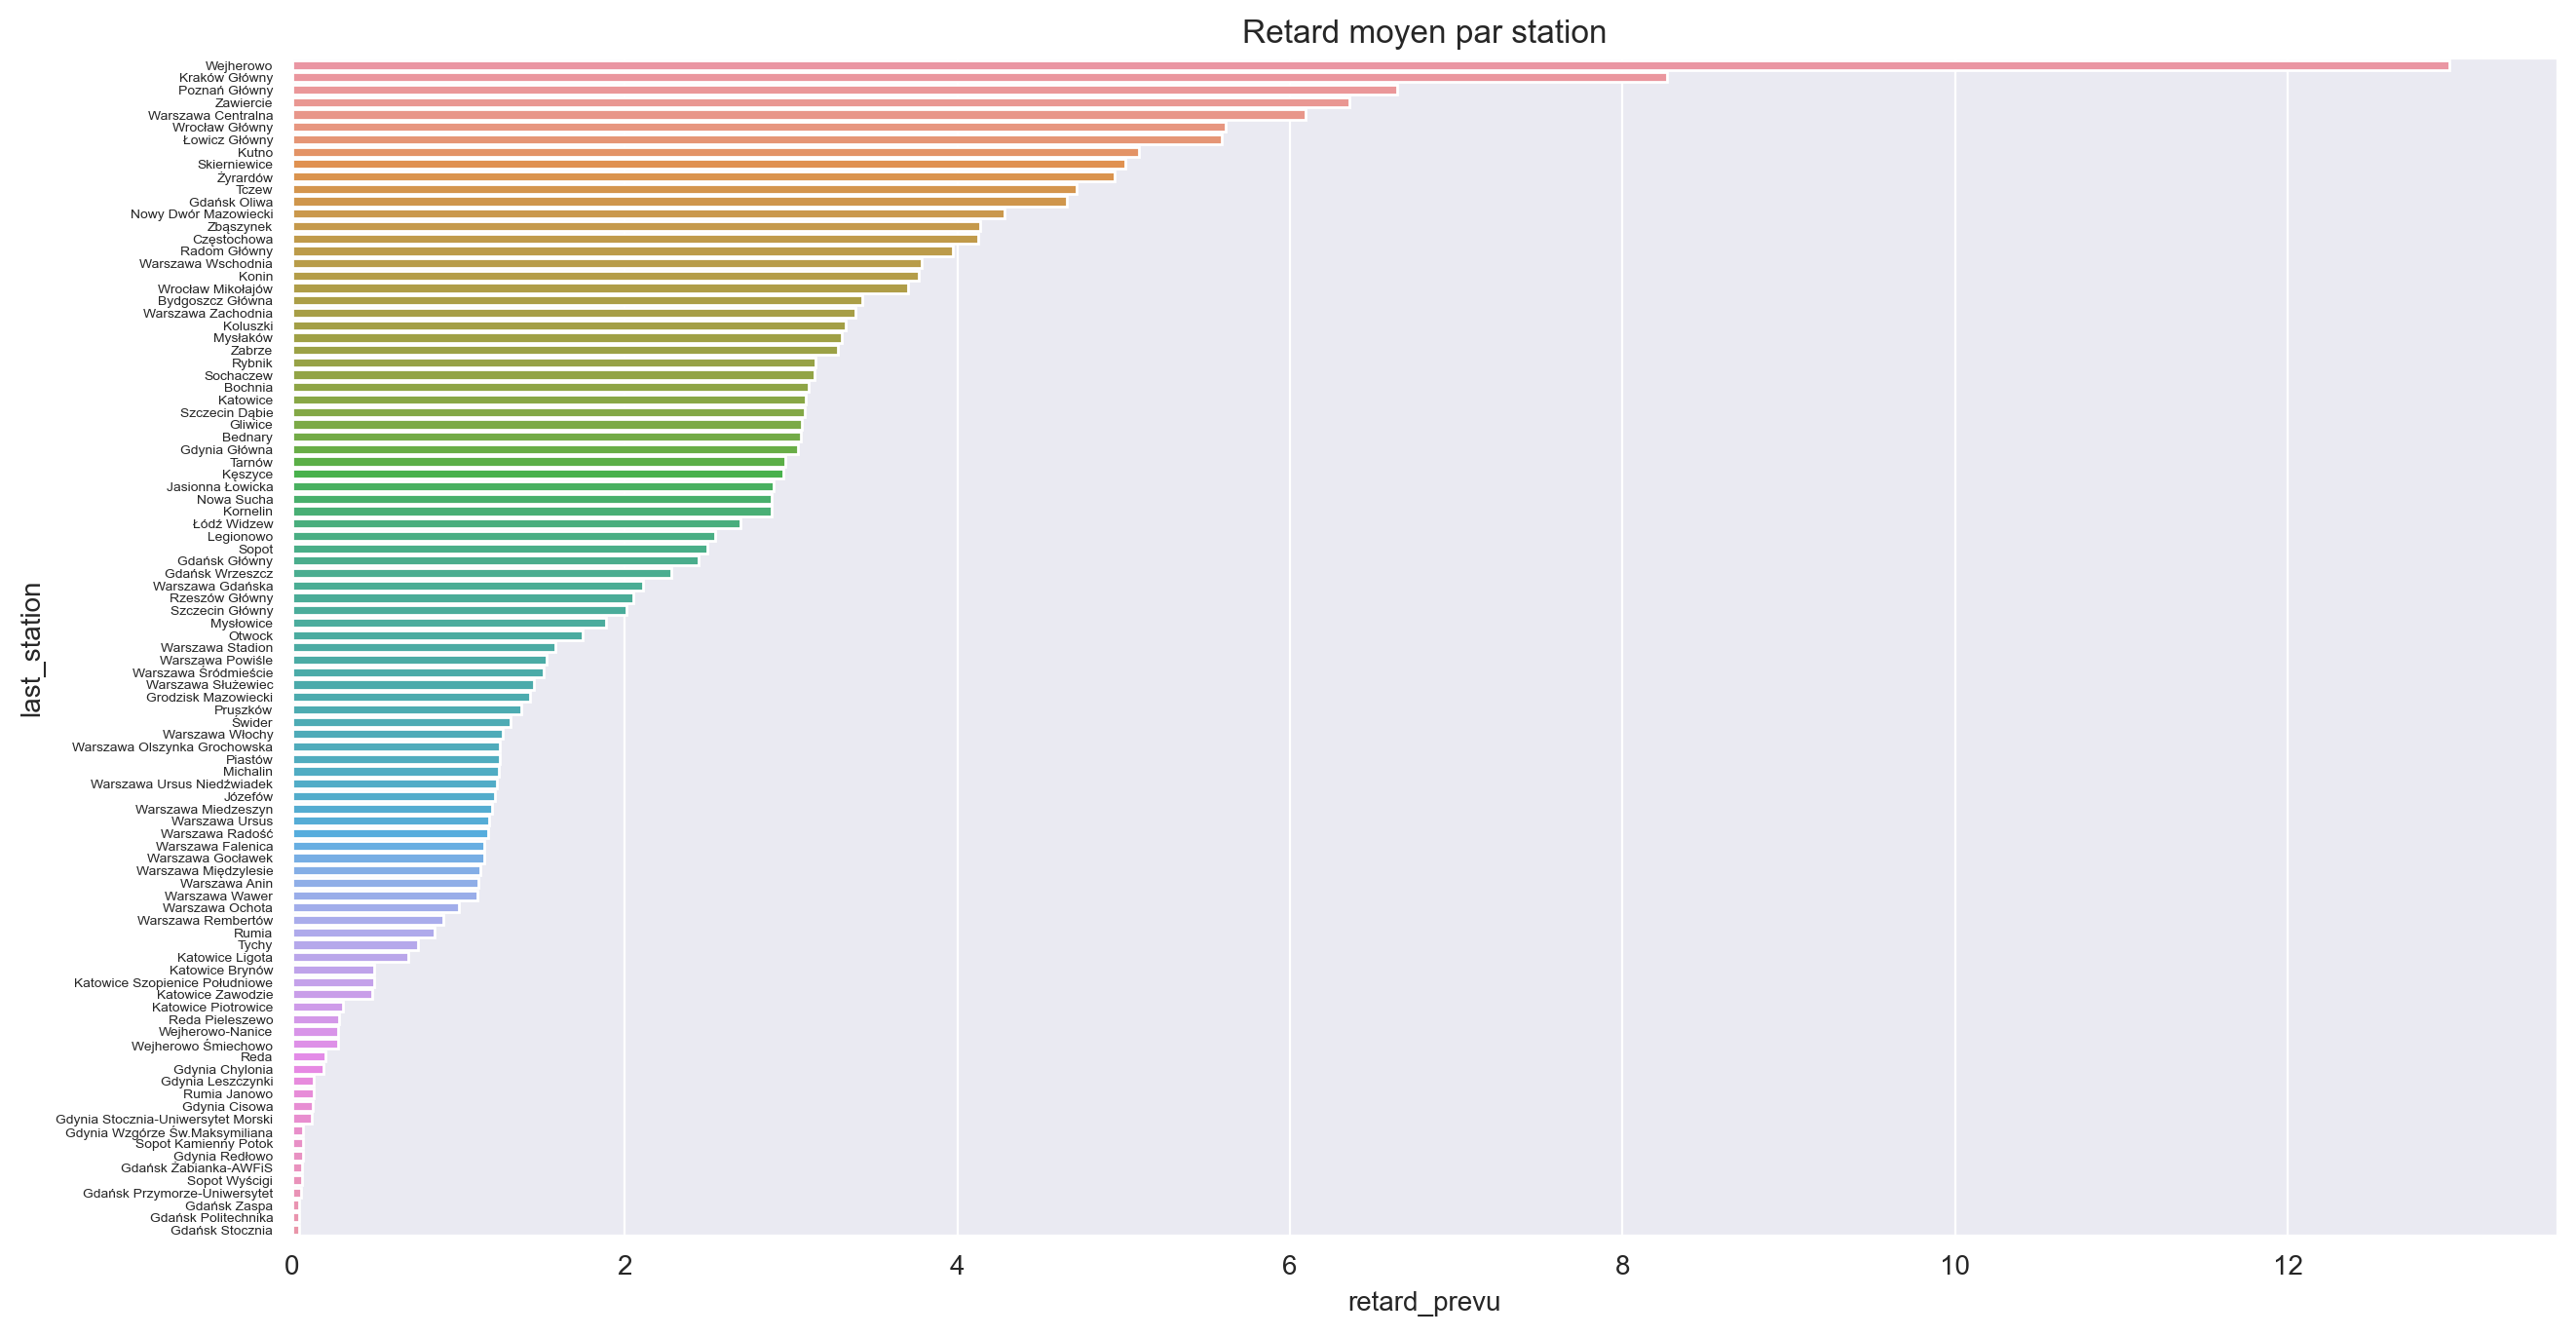

In [225]:
df_temp=df.groupby(["id_train","trajet","last_station"]).agg("mean").groupby("last_station").agg("mean").reset_index().sort_values("retard_prevu",ascending=False)
sns.barplot(data=df_temp,x="retard_prevu",y="last_station")

plt.yticks(fontsize=5)
plt.title("Retard moyen par station")
plt.show()